# Exploring Auto-Learning for Unsupervised Tokenization Hyper-Parameters based on cross-split F1, Compression Factor and Normalized Anti-Entropy - English

## Summary
- Self-tuning based on cross-split F1 (CSF1), "Compression factor" (C%) and Normalized Anti-Entropy (~S) and their means and products:
  - provide high correlations with F1
    - CSF1 0.95
    - C% 0.83
    - ~S 0.94
    - mean(C%+~S) 0.93
    - prod(C%*~S) 0.93
  - make it possible to self-tune hyper parameters 
    - **CSF1 = 1.0 => F1 = 0.95-0.99**
    - **mean(C%+~S) >= 0.325 => F1 = 0.98-0.99**
    - **prod(C%*~S) >= 0.0966 => F1 = 0.98-0.99**
    - ~S => F1 = 0.89-0.95 (alone works worse than mean/prod combination of ~S and C%) 
    - C% => F1 = 0.01 (alone does not work at all)

## TODO
- Evaluate on larger test corpus (use train for tuning but test for reference)


In [138]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']
if 'pygents.token_plot' in sys.modules:
    del sys.modules['pygents.token_plot']


from pygents.token import *
from pygents.text import *
from pygents.util import *
from pygents.plot import plot_bars, plot_dict, matrix_plot
from pygents.token_plot import *


In [66]:
path = '../../nlp/corpora/Chinese/'
test_df = pd.read_csv(os.path.join(path,'magicdata/zh_en_ru_100/CORPUS_ZH_EN_RU.txt'),delimiter='\t')
test_texts = list(test_df['en'])
print(len(test_texts))
test_df[['en']]

100


,en
0,What about medical insurance? As for my family...
1,"For those who have insurance, according to the..."
2,Need to realize the importance of having insur...
3,"In fact, this phenomenon is indeed very common..."
4,It is really necessary for this generation of ...
...,...
95,Ant Insurance does not only offer car insuranc...
96,"However, when buying a house, except for the d..."
97,This kind of financial investment has certain ...
98,"If your investment orientation is right, then ..."


## Basic test for Compression Ratio (C%) and Anormalized Shannon Anti-Entropy (~S) on Magicdata-100 test

In [67]:
ngram_params = [[1],[2],[3],[4]]
model_thresholds = [0]
token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
ref_tokenizer = DelimiterTokenizer()


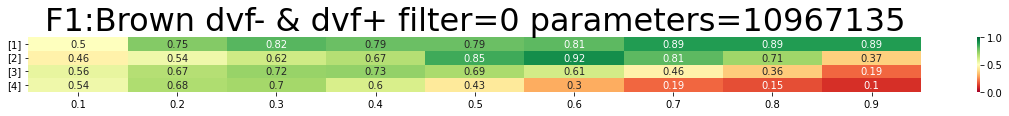

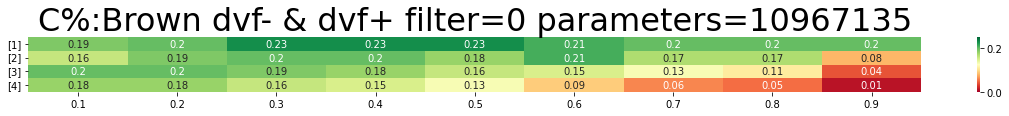

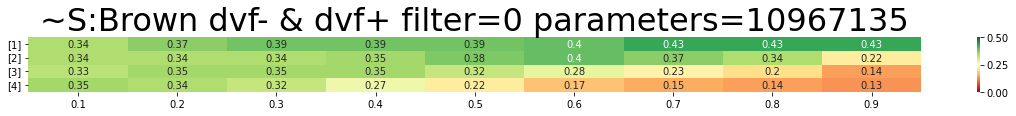

In [68]:
base = FreedomTokenizer(name='data/models/brown_nolines_chars_7a',max_n=7,mode='chars',debug=False)
title = 'Brown dvf- & dvf+'
metric100_list = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(test_texts,ref_tokenizer,FreedomBasedTokenizer(base,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metric100_list.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base

In [69]:
m_df = pd.DataFrame(metric_list,columns=['MT','NG','TT','F1','C%','~S'])
m_df['C%+~S'] = (m_df['C%'] + m_df['~S'])/2
m_df['C%*~S'] = (m_df['C%'] * m_df['~S'])
print('F1 X C%',m_df['F1'].corr(m_df['C%']))
print('F1 X SH',m_df['F1'].corr(m_df['~S']))
print('F1 X C%+~S',m_df['F1'].corr(m_df['C%+~S']))
print('F1 X C%*~S',m_df['F1'].corr(m_df['C%*~S']))
m_df


F1 X C% 0.8996190825684602
F1 X SH 0.9162474694922631
F1 X C%+~S 0.9261196504513362
F1 X C%*~S 0.9581012716513263


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S
0,0.0,[1],0.1,0.54,0.37,0.49,0.430,0.1813
1,0.0,[1],0.2,0.78,0.40,0.51,0.455,0.2040
2,0.0,[1],0.3,0.80,0.40,0.51,0.455,0.2040
3,0.0,[1],0.4,0.79,0.39,0.52,0.455,0.2028
4,0.0,[1],0.5,0.78,0.39,0.52,0.455,0.2028
...,...,...,...,...,...,...,...,...
625,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.5,0.42,0.33,0.35,0.340,0.1155
626,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.6,0.25,0.25,0.27,0.260,0.0675
627,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.7,0.12,0.14,0.19,0.165,0.0266
628,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.8,0.05,0.07,0.17,0.120,0.0119


## Explore self-tuning on Compression Ratio (C%) and Anormalized Shannon Anti-Entropy (~S) on Magicdata-100 test

In [70]:
ngram_params = [[1],[2],[3],[4],[5],[6],[7],[1,2],[2,3],[1,2,3],[1,2,3,4],[4,5,6,7],[1,2,3,4,5],[1,2,3,4,5,6,7]]
model_thresholds = [0,0.0001,0.001,0.01,0.1]
token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
ref_tokenizer = DelimiterTokenizer()


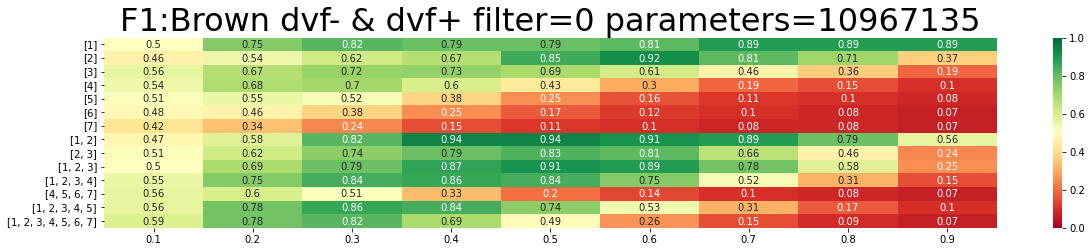

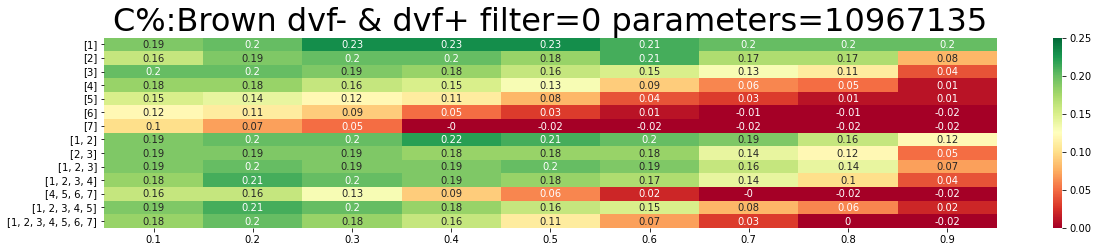

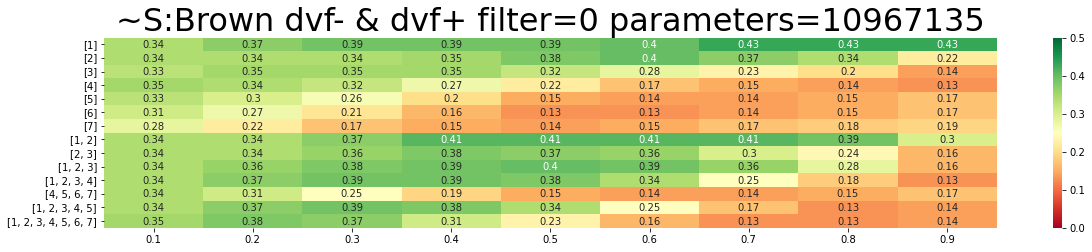

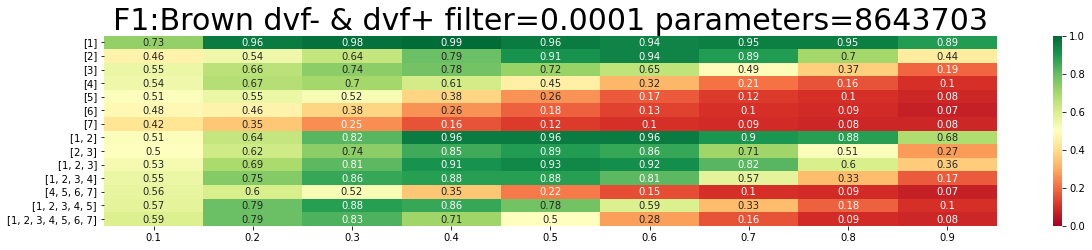

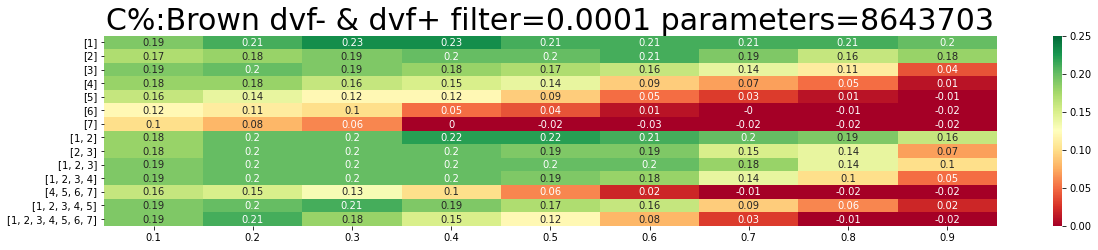

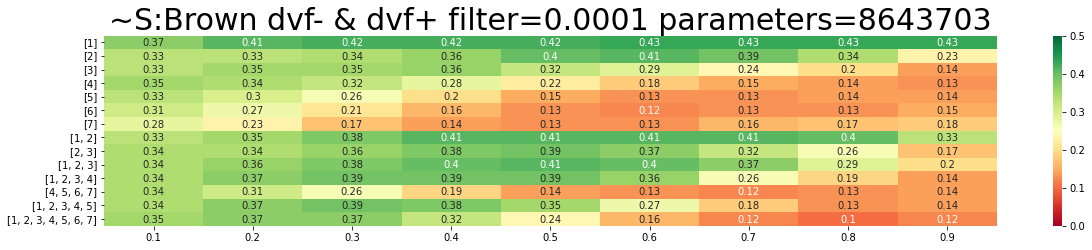

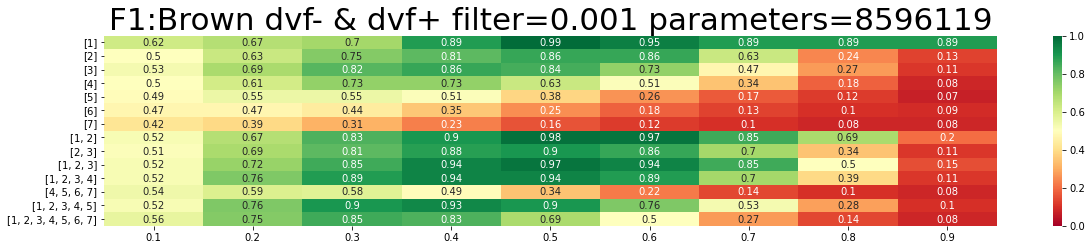

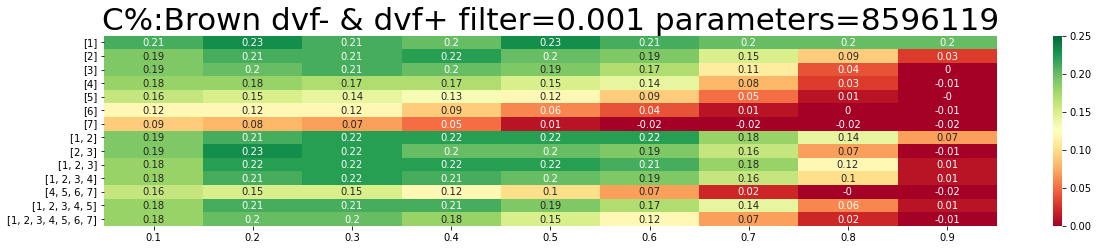

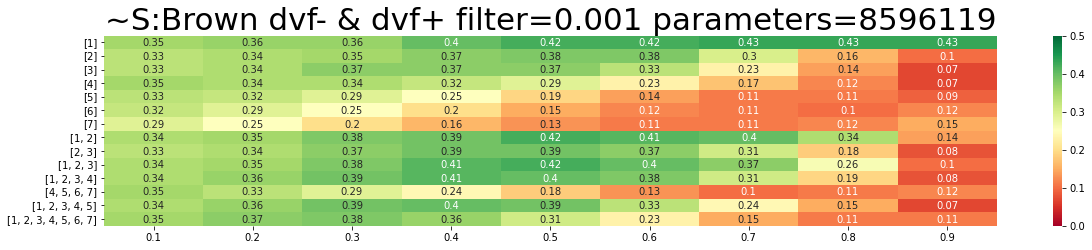

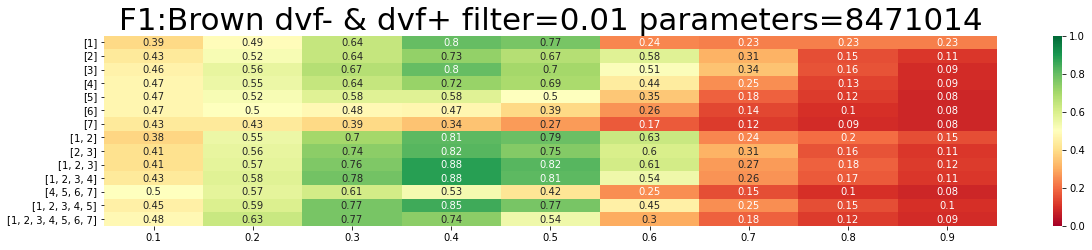

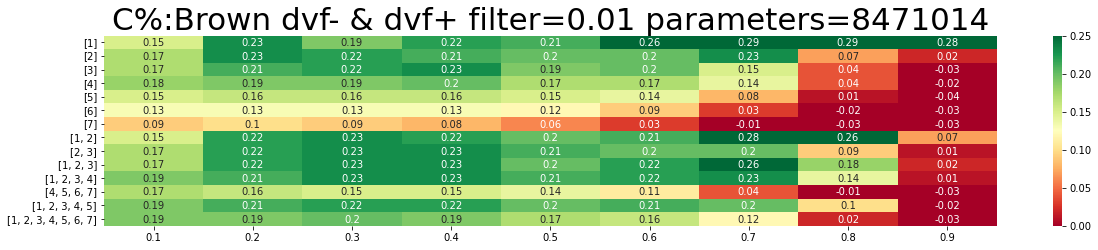

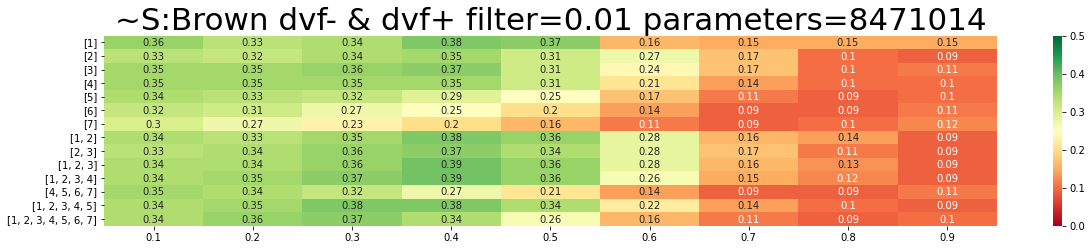

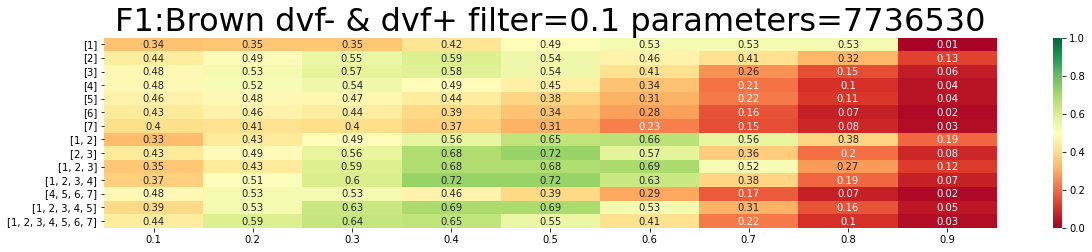

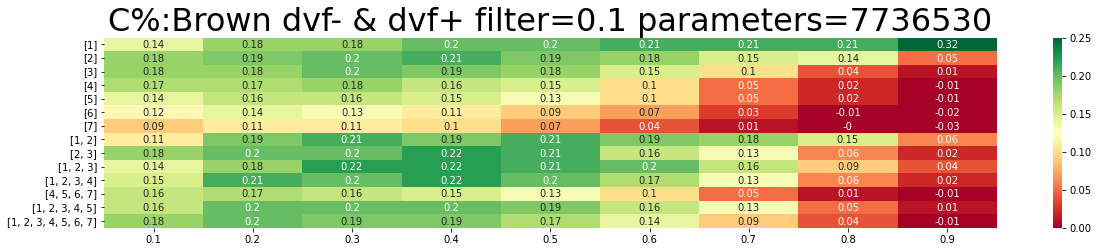

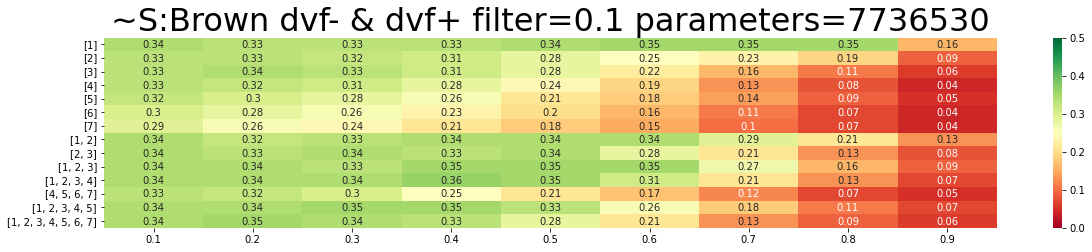

In [71]:
base = FreedomTokenizer(name='data/models/brown_nolines_chars_7a',max_n=7,mode='chars',debug=False)
title = 'Brown dvf- & dvf+'
metric100_list = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(test_texts,ref_tokenizer,FreedomBasedTokenizer(base,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metric100_list.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


## Next, evaluate mutual/cross F1 between two models of the split data set against F1 on reference Tokenization on Magicdata-100 test


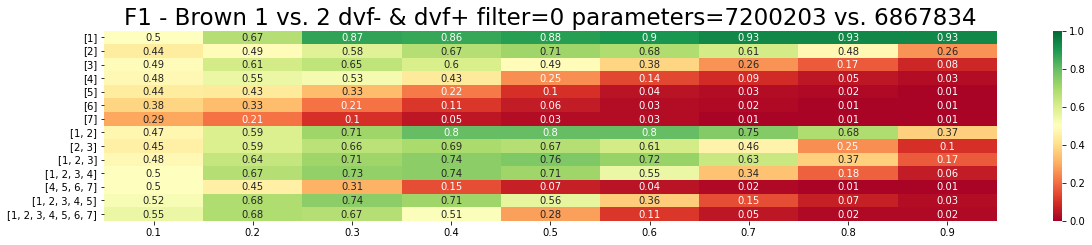

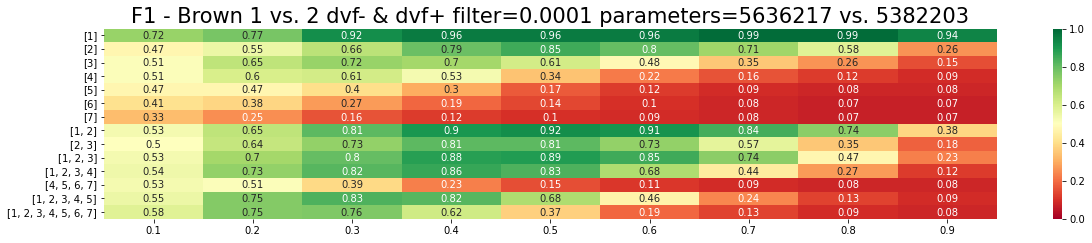

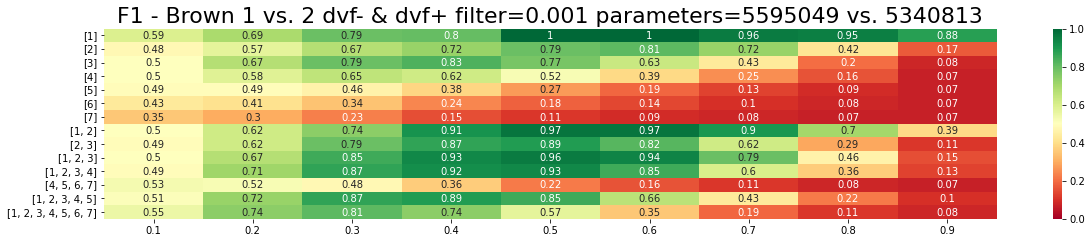

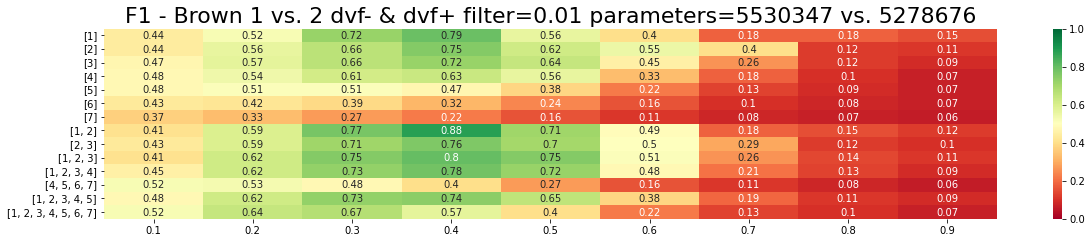

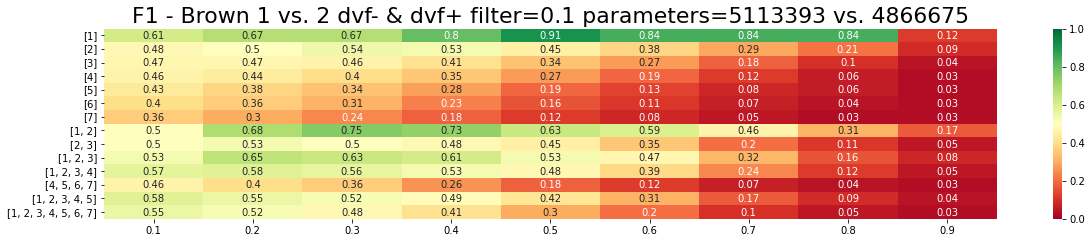

In [79]:
base1 = FreedomTokenizer(name='data/models/brown_chars_7_1',max_n=7,mode='chars',debug=False)
base2 = FreedomTokenizer(name='data/models/brown_chars_7_2',max_n=7,mode='chars',debug=False)
title = 'F1 - Brown 1 vs. 2 dvf- & dvf+'
cross100_f_list = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base1.model,model_threshold)
        model_compress_with_loss(base2.model,model_threshold)
    parameters1 = base1.count_params()
    parameters2 = base2.count_params()
    metrics = evaluate_freedom_tokenizer_options(test_texts,
        FreedomBasedTokenizer(base1,'dvf-','dvf+'),
        FreedomBasedTokenizer(base2,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={} vs. {}".format(title,model_threshold,parameters1,parameters2))
    cross100_f_list.extend([(model_threshold,m[0],m[1],m[2]) for m in metrics])
del base1
del base2


In [149]:
m_df = pd.DataFrame(metric100_list,columns=['MT','NG','TT','F1','C%','~S'])
m_cross_df = pd.DataFrame(cross100_f_list,columns=['MT','NG','TT','CSF1'])

m_df['CSF1'] = m_cross_df['CSF1']
m_df['C%+~S'] = (m_df['C%'] + m_df['~S'])/2
m_df['C%*~S'] = (m_df['C%'] * m_df['~S'])
m_df['CSF1+~S'] = (m_df['CSF1'] + m_df['~S'])/2
m_df['CSF1*~S'] = (m_df['CSF1'] * m_df['~S'])
m_df['CSF1+C%'] = (m_df['CSF1'] + m_df['C%'])/2
m_df['CSF1*C%'] = (m_df['CSF1'] * m_df['C%'])
m_df['CSF1+~S+C%'] = (m_df['CSF1'] + m_df['~S'] + m_df['C%'])/3
m_df['CSF1*~S*C%'] = (m_df['CSF1'] * m_df['~S'] * m_df['C%'])

print('CSF1 X ~S',m_df['CSF1'].corr(m_df['~S']))
print('CSF1 X C%',m_df['CSF1'].corr(m_df['C%']))
print('~S X C%',m_df['~S'].corr(m_df['C%']))


top_df = None
for m in ['CSF1','~S','C%','CSF1+~S','CSF1*~S','CSF1+C%','CSF1*C%','C%+~S','C%*~S','CSF1+~S+C%','CSF1*~S*C%']:
    df = m_df.sort_values(by=[m,'F1'],ascending=False)[['F1']][:1]
    df.insert(0,'metric',[m])
    df.insert(2,'corr',[round(m_df['F1'].corr(m_df[m]),2)])
    if top_df is None:
        top_df = df
    else:
        top_df = top_df.append(df)
top_df.sort_values(by=['F1','corr','metric'],ascending=False,inplace=True)
top_df


CSF1 X ~S 0.9405621899227956
CSF1 X C% 0.8337429708931936
~S X C% 0.8486777464363431


,metric,F1,corr
256,CSF1+~S+C%,0.99,0.96
256,CSF1+~S,0.99,0.96
256,CSF1+C%,0.99,0.95
256,CSF1,0.99,0.95
129,C%+~S,0.99,0.93
129,C%*~S,0.99,0.93
256,CSF1*C%,0.99,0.92
256,CSF1*~S*C%,0.99,0.91
132,~S,0.95,0.94
132,CSF1*~S,0.95,0.94


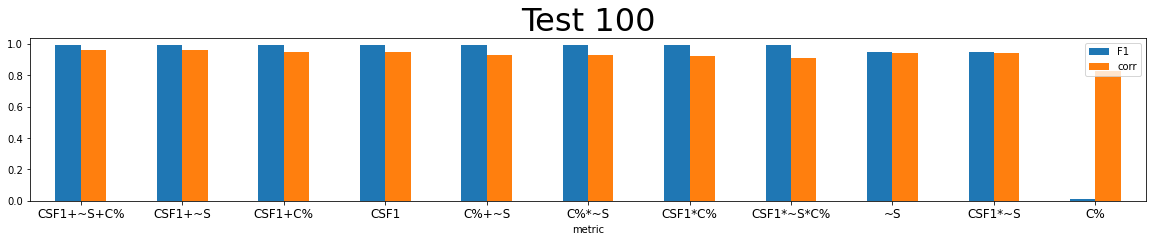

In [150]:
plot_bars(top_df,'metric',['F1','corr'],title='Test 100',fontsize=12)


In [ ]:
break

## Further, repeat the same experiment using self-tuning metrics (CFF1, C% and ~S) based on 1K subset of the train set itself, to compare against F1 of test set in the same space of Hyper-Parameters

In [41]:
brown_lines = url_lines("http://www.sls.hawaii.edu/bley-vroman/brown_nolines.txt")
print(len(brown_lines))


19811


In [45]:
test_texts = [l.strip() for l in brown_lines if not len(l.strip()) == 0 or '#' in l][0::14]
print(len(test_texts))


1025


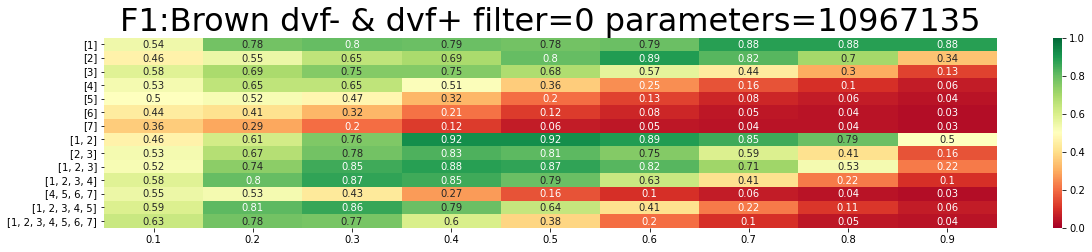

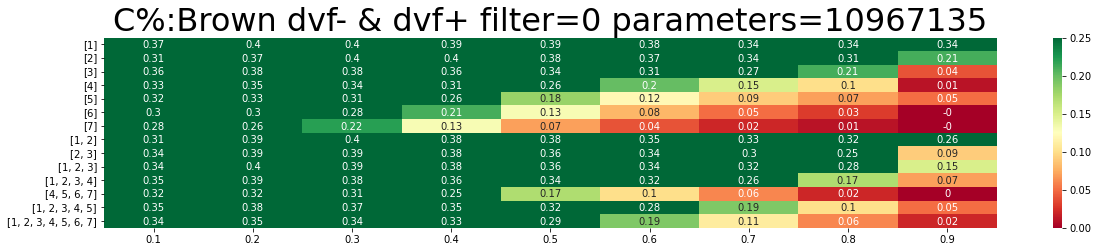

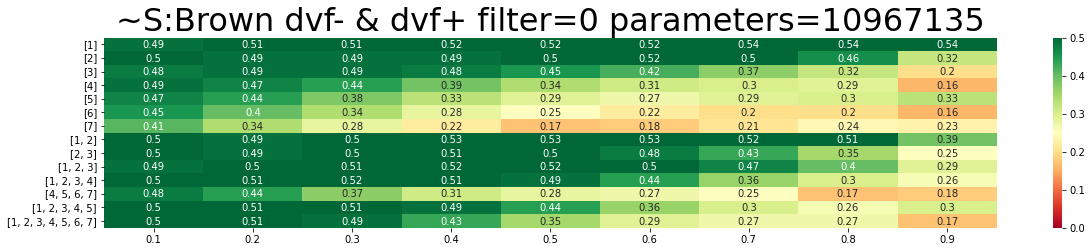

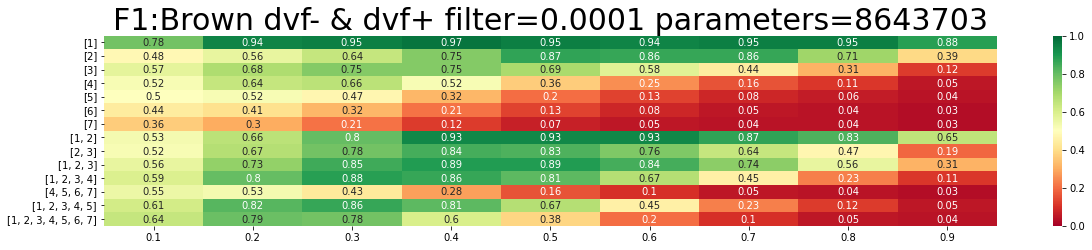

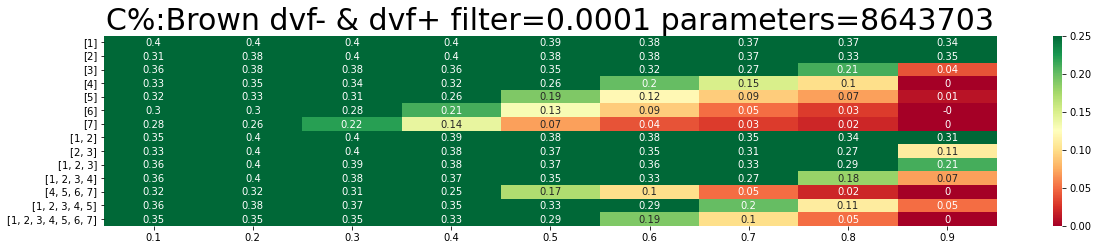

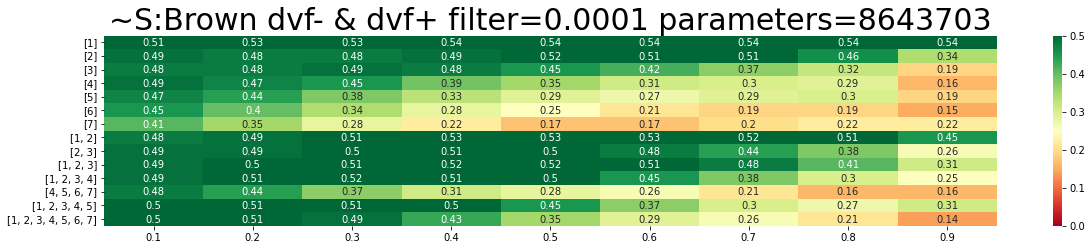

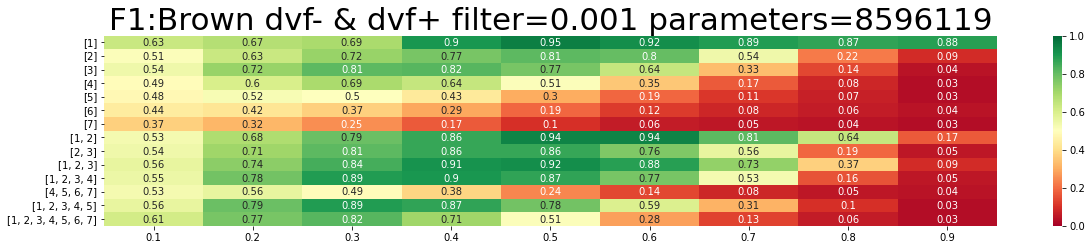

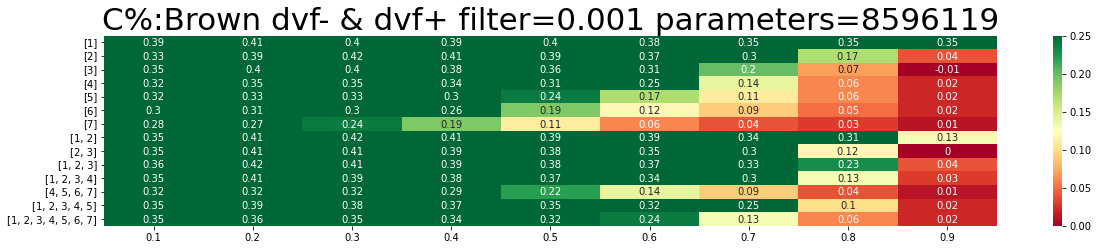

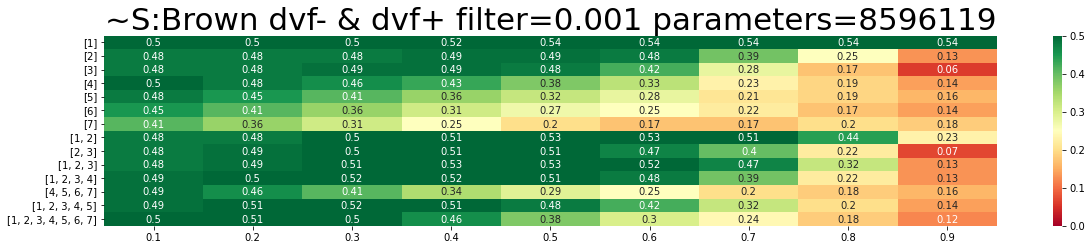

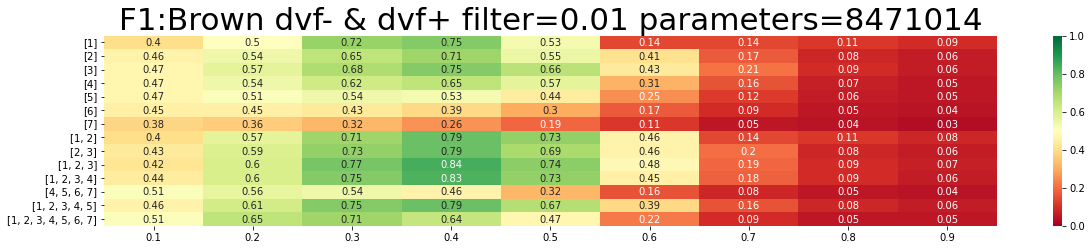

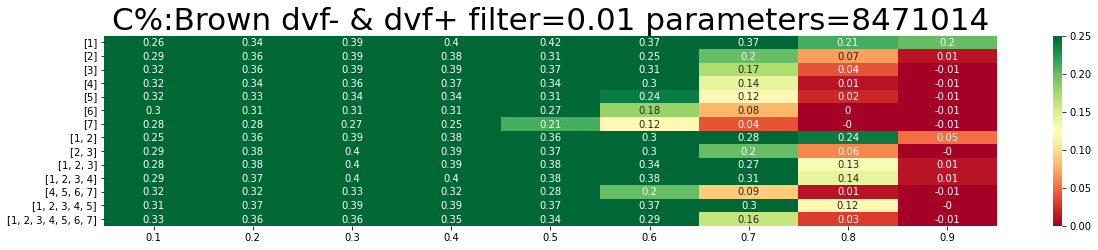

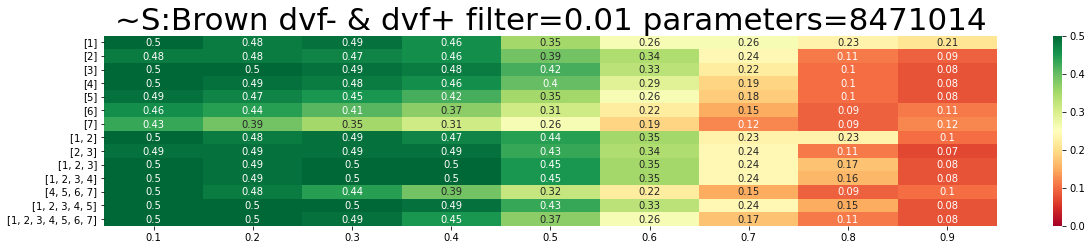

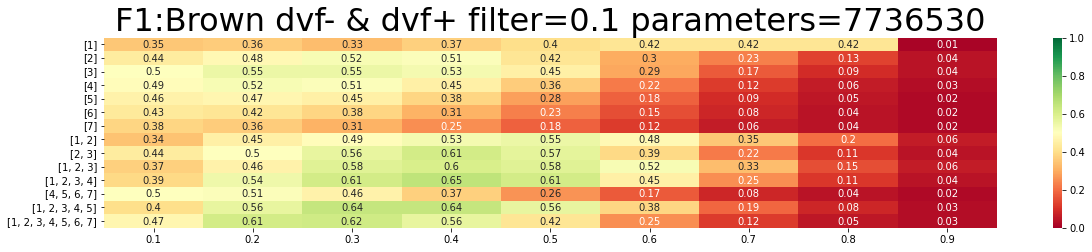

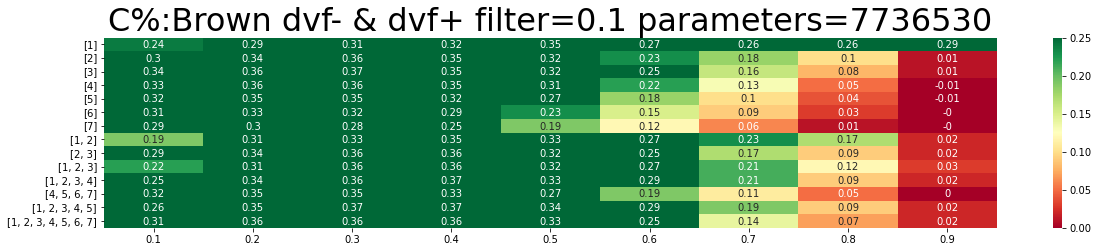

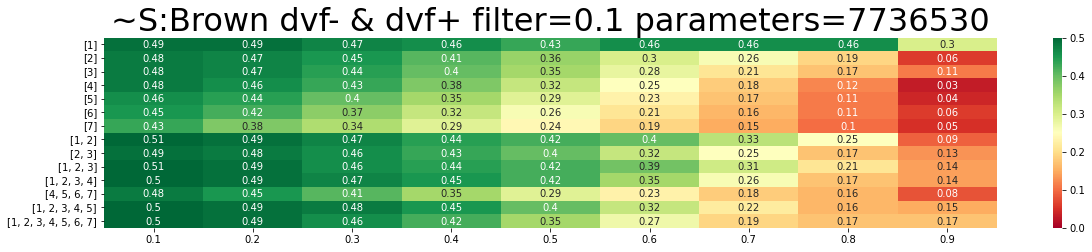

In [46]:
base = FreedomTokenizer(name='data/models/brown_nolines_chars_7a',max_n=7,mode='chars',debug=False)
title = 'Brown dvf- & dvf+'
metric_list = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(test_texts,ref_tokenizer,FreedomBasedTokenizer(base,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metric_list.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base
#Timing ~18 hours


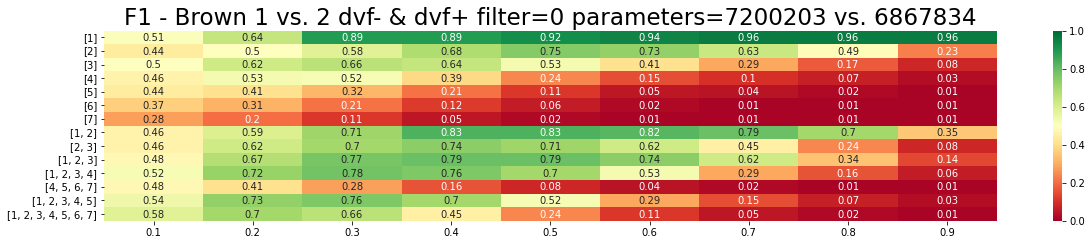

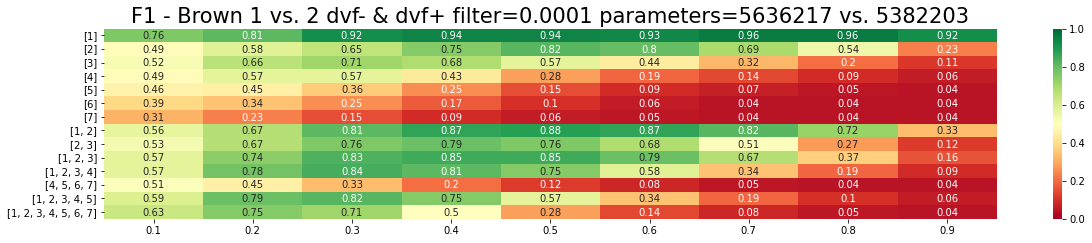

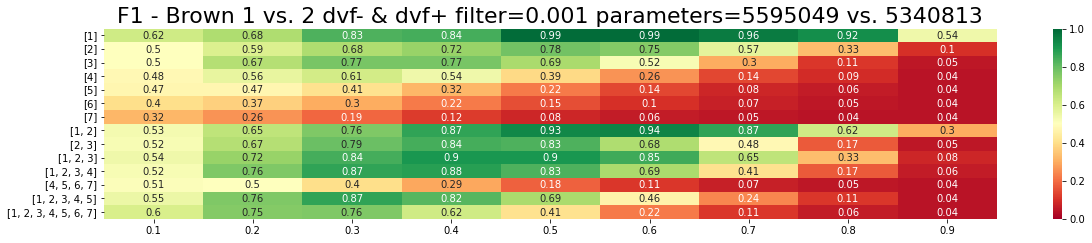

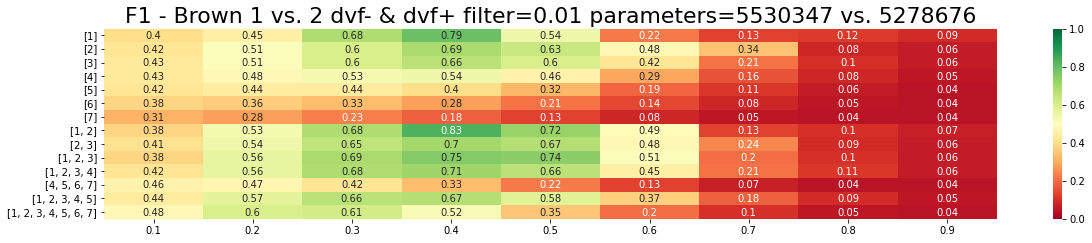

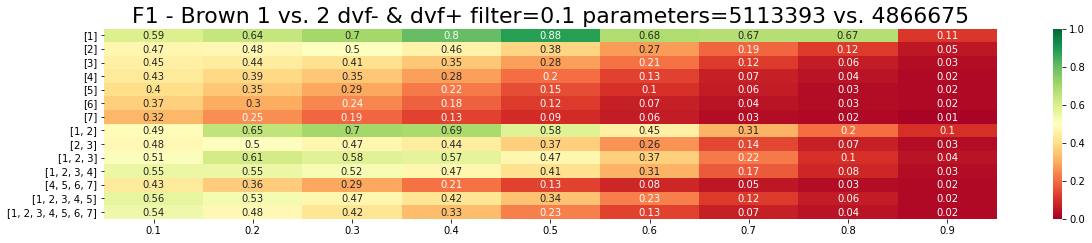

In [47]:
base1 = FreedomTokenizer(name='data/models/brown_chars_7_1',max_n=7,mode='chars',debug=False)
base2 = FreedomTokenizer(name='data/models/brown_chars_7_2',max_n=7,mode='chars',debug=False)
title = 'F1 - Brown 1 vs. 2 dvf- & dvf+'
cross_f_list = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base1.model,model_threshold)
        model_compress_with_loss(base2.model,model_threshold)
    parameters1 = base1.count_params()
    parameters2 = base2.count_params()
    metrics = evaluate_freedom_tokenizer_options(test_texts,
        FreedomBasedTokenizer(base1,'dvf-','dvf+'),
        FreedomBasedTokenizer(base2,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={} vs. {}".format(title,model_threshold,parameters1,parameters2))
    cross_f_list.extend([(model_threshold,m[0],m[1],m[2]) for m in metrics])
del base1
del base2
#Timing ~20+ hours (since Noon June 6)


In [151]:
m_df = pd.DataFrame(metric_list,columns=['MT','NG','TT','F1','C%','~S'])
m_cross_df = pd.DataFrame(cross_f_list,columns=['MT','NG','TT','CSF1'])

m_df['CSF1'] = m_cross_df['CSF1']
m_df['C%+~S'] = (m_df['C%'] + m_df['~S'])/2
m_df['C%*~S'] = (m_df['C%'] * m_df['~S'])
m_df['CSF1+~S'] = (m_df['CSF1'] + m_df['~S'])/2
m_df['CSF1*~S'] = (m_df['CSF1'] * m_df['~S'])
m_df['CSF1+C%'] = (m_df['CSF1'] + m_df['C%'])/2
m_df['CSF1*C%'] = (m_df['CSF1'] * m_df['C%'])
m_df['CSF1+~S+C%'] = (m_df['CSF1'] + m_df['~S'] + m_df['C%'])/3
m_df['CSF1*~S*C%'] = (m_df['CSF1'] * m_df['~S'] * m_df['C%'])

print('CSF1 X ~S',m_df['CSF1'].corr(m_df['~S']))
print('CSF1 X C%',m_df['CSF1'].corr(m_df['C%']))
print('~S X C%',m_df['~S'].corr(m_df['C%']))


top_df = None
for m in ['CSF1','~S','C%','CSF1+~S','CSF1*~S','CSF1+C%','CSF1*C%','C%+~S','C%*~S','CSF1+~S+C%','CSF1*~S*C%']:
    df = m_df.sort_values(by=[m,'F1'],ascending=False)[['F1']][:1]
    df.insert(0,'metric',[m])
    df.insert(2,'corr',[round(m_df['F1'].corr(m_df[m]),2)])
    if top_df is None:
        top_df = df
    else:
        top_df = top_df.append(df)
top_df.sort_values(by=['F1','corr','metric'],ascending=False,inplace=True)
top_df


CSF1 X ~S 0.8990277056710079
CSF1 X C% 0.8566425667348444
~S X C% 0.9232488077016668


,metric,F1,corr
129,C%*~S,0.97,0.96
129,C%+~S,0.97,0.93
129,~S,0.97,0.92
256,CSF1+~S+C%,0.95,0.97
256,CSF1+~S,0.95,0.97
256,CSF1+C%,0.95,0.97
256,CSF1*C%,0.95,0.96
256,CSF1,0.95,0.96
256,CSF1*~S*C%,0.95,0.95
256,CSF1*~S,0.95,0.95


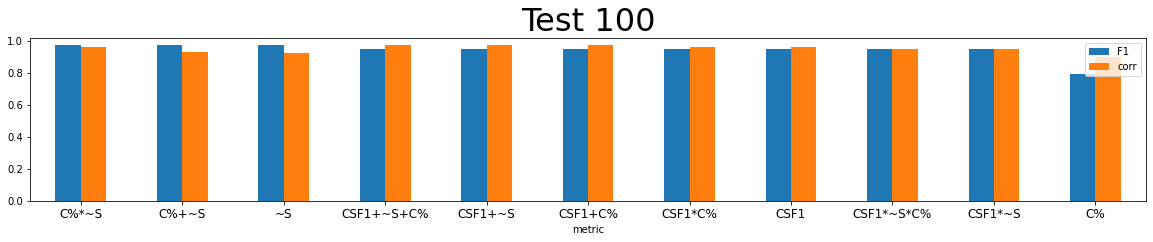

In [152]:
plot_bars(top_df,'metric',['F1','corr'],title='Test 100',fontsize=12)


In [153]:
#TODO dot plots
#TODO conclude
